### Comparing Aggregate Models for Regression

This try-it focuses on utilizing ensemble models in a regression setting.  Much like you have used individual classification estimators to form an ensemble of estimators -- here your goal is to explore ensembles for regression models.  As with your earlier assignment, you will use scikitlearn to carry out the ensembles using the `VotingRegressor`.   


#### Dataset and Task

Below, a dataset containing census information on individuals and their hourly wage is loaded using the `fetch_openml` function.  OpenML is another repository for datasets [here](https://www.openml.org/).  Your task is to use ensemble methods to explore predicting the `wage` column of the data.  Your ensemble should at the very least consider the following models:

- `LinearRegression` -- perhaps you even want the `TransformedTargetRegressor` here.
- `KNeighborsRegressor`
- `DecisionTreeRegressor`
- `Ridge`
- `SVR`

Tune the `VotingRegressor` to try to optimize the prediction performance and determine if the wisdom of the crowd performed better in this setting than any of the individual models themselves.  Report back on your findings and discuss the interpretability of your findings.  Is there a way to determine what features mattered in predicting wages?

### Resources

Check out https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html

Also, module 9 try-it: try_it_9.2-starter.Aykan.ipynb for data file preprocessing!


In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from sklearn.ensemble import VotingRegressor
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn import set_config

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector, TransformedTargetRegressor
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel
from sklearn.model_selection import train_test_split, RepeatedKFold, cross_validate
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error
from sklearn import set_config
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
#from category_encoders import TargetEncoder

from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor

In [2]:
tstart = datetime.now()
print(tstart)

2022-08-21 16:21:14.612396


In [3]:
set_config(display="diagram")

In [4]:
survey = fetch_openml(data_id=534, as_frame=True).frame

### Exploratory Data Analysis

In [5]:
survey.head()

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,WAGE,AGE,RACE,OCCUPATION,SECTOR,MARR
0,8.0,no,female,21.0,not_member,5.10,35.0,Hispanic,Other,Manufacturing,Married
1,9.0,no,female,42.0,not_member,4.95,57.0,White,Other,Manufacturing,Married
2,12.0,no,male,1.0,not_member,6.67,19.0,White,Other,Manufacturing,Unmarried
3,12.0,no,male,4.0,not_member,4.00,22.0,White,Other,Other,Unmarried
4,12.0,no,male,17.0,not_member,7.50,35.0,White,Other,Other,Married


In [6]:
survey.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 534 entries, 0 to 533
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   EDUCATION   534 non-null    float64 
 1   SOUTH       534 non-null    category
 2   SEX         534 non-null    category
 3   EXPERIENCE  534 non-null    float64 
 4   UNION       534 non-null    category
 5   WAGE        534 non-null    float64 
 6   AGE         534 non-null    float64 
 7   RACE        534 non-null    category
 8   OCCUPATION  534 non-null    category
 9   SECTOR      534 non-null    category
 10  MARR        534 non-null    category
dtypes: category(7), float64(4)
memory usage: 21.4 KB


In [7]:
survey.describe()

,EDUCATION,EXPERIENCE,WAGE,AGE
count,534.000000,534.000000,534.000000,534.000000
mean,13.018727,17.822097,9.024064,36.833333
std,2.615373,12.379710,5.139097,11.726573
min,2.000000,0.000000,1.000000,18.000000
25%,12.000000,8.000000,5.250000,28.000000
50%,12.000000,15.000000,7.780000,35.000000
75%,15.000000,26.000000,11.250000,44.000000
max,18.000000,55.000000,44.500000,64.000000


In [8]:
survey.describe(include="all")

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,WAGE,AGE,RACE,OCCUPATION,SECTOR,MARR
count,534.000000,534,534,534.000000,534,534.000000,534.000000,534,534,534,534
unique,NaN,2,2,NaN,2,NaN,NaN,3,6,3,2
top,NaN,no,male,NaN,not_member,NaN,NaN,White,Other,Other,Married
freq,NaN,378,289,NaN,438,NaN,NaN,440,156,411,350
mean,13.018727,NaN,NaN,17.822097,NaN,9.024064,36.833333,NaN,NaN,NaN,NaN
std,2.615373,NaN,NaN,12.379710,NaN,5.139097,11.726573,NaN,NaN,NaN,NaN
min,2.000000,NaN,NaN,0.000000,NaN,1.000000,18.000000,NaN,NaN,NaN,NaN
25%,12.000000,NaN,NaN,8.000000,NaN,5.250000,28.000000,NaN,NaN,NaN,NaN
50%,12.000000,NaN,NaN,15.000000,NaN,7.780000,35.000000,NaN,NaN,NaN,NaN
75%,15.000000,NaN,NaN,26.000000,NaN,11.250000,44.000000,NaN,NaN,NaN,NaN


In [9]:
def object_values(data):
    for c in data.select_dtypes(include = 'category').columns:
        print(c, '\n============================')
        print(data[c].value_counts(), '\n============================')

In [10]:
object_values(survey)

SOUTH 
no     378
yes    156
Name: SOUTH, dtype: int64 
SEX 
male      289
female    245
Name: SEX, dtype: int64 
UNION 
not_member    438
member         96
Name: UNION, dtype: int64 
RACE 
White       440
Other        67
Hispanic     27
Name: RACE, dtype: int64 
OCCUPATION 
Other           156
Professional    105
Clerical         97
Service          83
Management       55
Sales            38
Name: OCCUPATION, dtype: int64 
SECTOR 
Other            411
Manufacturing     99
Construction      24
Name: SECTOR, dtype: int64 
MARR 
Married      350
Unmarried    184
Name: MARR, dtype: int64 


### Prepare Data

In [108]:
X, y = survey.drop(columns='WAGE'), survey['WAGE']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 93, test_size = 0.3)

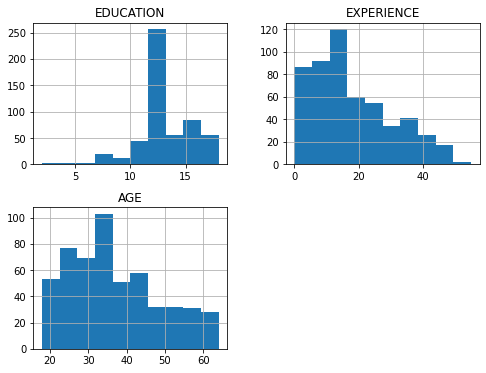

In [12]:
X.hist(figsize = (8, 6))
plt.show()

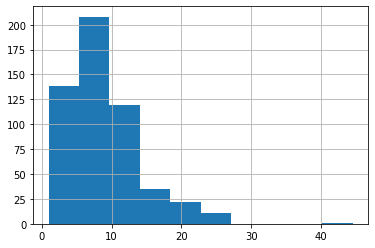

In [13]:
y.hist()
plt.show()

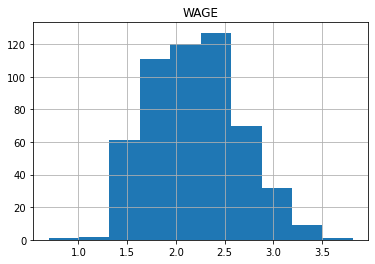

In [14]:
# test out logarithm on target column - transform target!
np.log1p(y).hist()
plt.title('WAGE')
plt.show()

### Feature Transformation

In [15]:
# Instantiate OneHotEncoder for tranform features
ohe = OneHotEncoder(sparse = False, drop='if_binary')
print(ohe.fit_transform(survey.select_dtypes(include = 'category'))[:5])

[[0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1.]
 [0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0.]]


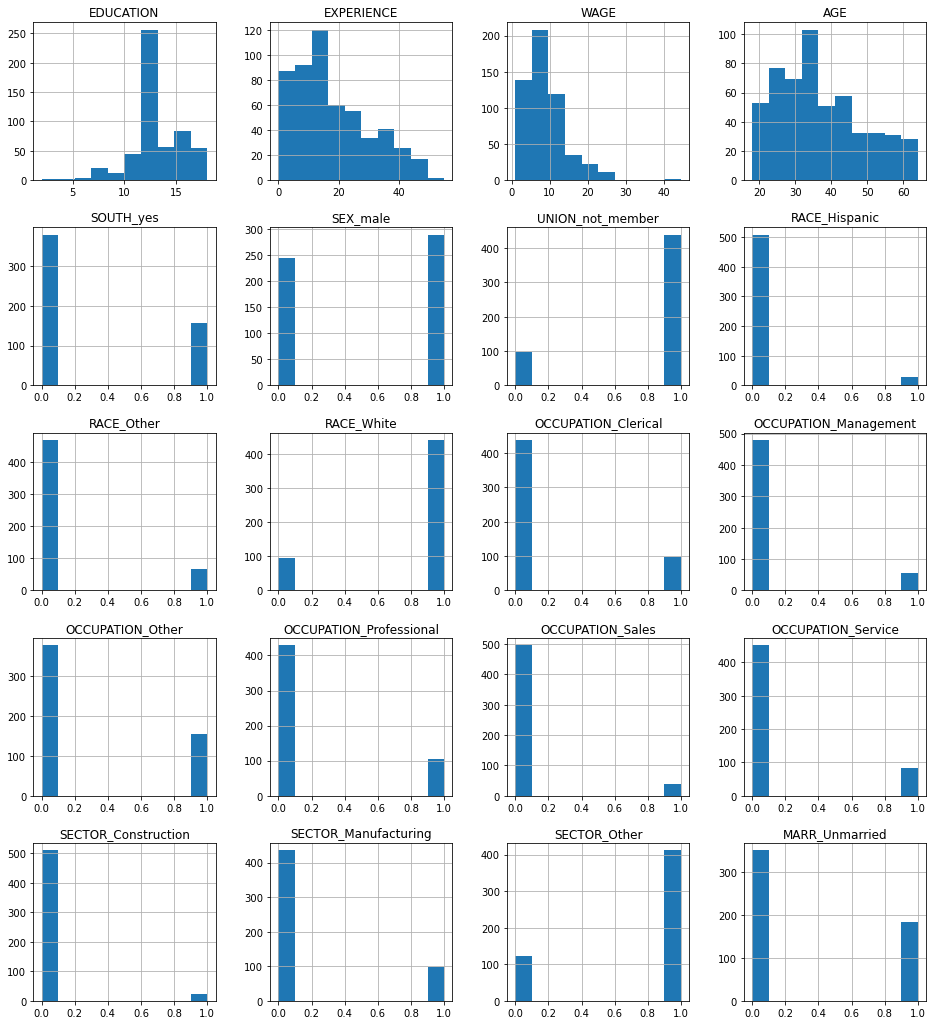

In [16]:
# tranform features and plot histogram
pd.merge(
    survey.select_dtypes(include=np.number),
    pd.DataFrame(ohe.fit_transform(X.select_dtypes(include = 'category')),
             columns=ohe.get_feature_names_out()),
    left_index=True, right_index=True
).hist(figsize = (16, 18))
plt.show()

Looking closely at the WAGE distribution reveals that it has a long tail. For this reason, we should take its logarithm to turn it approximately into a normal distribution (linear models such as ridge or lasso work best for a normal distribution of error).

The WAGE is increasing when EDUCATION is increasing. Note that the dependence between WAGE and EDUCATION represented here is a marginal dependence, i.e., it describes the behavior of a specific variable without keeping the others fixed.

Also, the EXPERIENCE and AGE are strongly linearly correlated.

In [113]:
survey.select_dtypes(include=np.number).columns

Index(['EDUCATION', 'EXPERIENCE', 'WAGE', 'AGE'], dtype='object')

In [17]:
pd.merge(
    survey.select_dtypes(include=np.number),
    pd.DataFrame(ohe.fit_transform(X.select_dtypes(include = 'category')),
             columns=ohe.get_feature_names_out()),
    left_index=True, right_index=True
)

,EDUCATION,EXPERIENCE,WAGE,AGE,SOUTH_yes,SEX_male,UNION_not_member,RACE_Hispanic,RACE_Other,RACE_White,OCCUPATION_Clerical,OCCUPATION_Management,OCCUPATION_Other,OCCUPATION_Professional,OCCUPATION_Sales,OCCUPATION_Service,SECTOR_Construction,SECTOR_Manufacturing,SECTOR_Other,MARR_Unmarried
0,8.0,21.0,5.10,35.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,9.0,42.0,4.95,57.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,12.0,1.0,6.67,19.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,12.0,4.0,4.00,22.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
4,12.0,17.0,7.50,35.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
529,18.0,5.0,11.36,29.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
530,12.0,33.0,6.10,51.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
531,17.0,25.0,23.25,48.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
532,12.0,13.0,19.88,31.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


<Figure size 432x288 with 0 Axes>

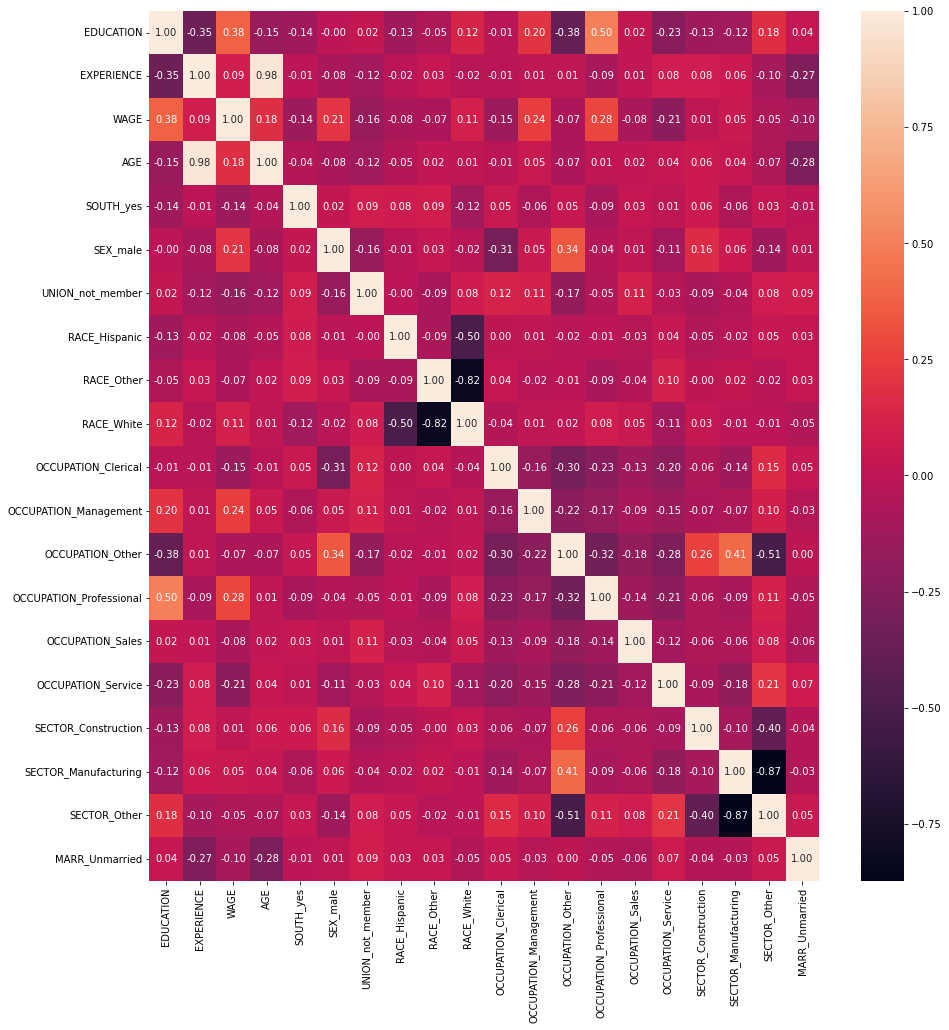

In [18]:
# correlation
# tranform features and plot histogram
plt.tight_layout()
plt.subplots(figsize=(15,16))
sns.heatmap(
    pd.merge(
        survey.select_dtypes(include=np.number),
        pd.DataFrame(ohe.fit_transform(X.select_dtypes(include = 'category')),
                 columns=ohe.get_feature_names_out()),
        left_index=True, right_index=True
    ).corr(),
annot=True, fmt='.2f')
plt.show()

### Building Models

In [19]:
X.select_dtypes(include = 'category').columns

Index(['SOUTH', 'SEX', 'UNION', 'RACE', 'OCCUPATION', 'SECTOR', 'MARR'], dtype='object')

In [20]:
%%time
complexity = 5
train_mses = []
test_mses = []
features = [c for c in X.select_dtypes(include = 'category').columns if c in X.columns]
for d in range(1, complexity):
    #create pipeline with PolynomialFeatures degree d 
    ohe_step = make_column_transformer((OneHotEncoder(drop = 'if_binary'), features),
                                       remainder="passthrough" )
    
    pipe = Pipeline([('transformer', ohe_step),
                     ('polyfeatures', PolynomialFeatures(degree = d, include_bias = False)),
                     ('scaler', StandardScaler()),
                     ('linreg', LinearRegression())])
    #fit on train
    pipe.fit(X_train, y_train)
    #compute mean squared errors
    #predict on train and test
    train_mses.append(mean_squared_error(y_train, pipe.predict(X_train)))
    test_mses.append(mean_squared_error(y_test, pipe.predict(X_test)))
# Answer check
print(pipe.named_steps)
print(train_mses)
print(test_mses)
print(pipe.score(X_test, y_test))
pipe

{'transformer': ColumnTransformer(remainder='passthrough',
                  transformers=[('onehotencoder',
                                 OneHotEncoder(drop='if_binary'),
                                 ['SOUTH', 'SEX', 'UNION', 'RACE', 'OCCUPATION',
                                  'SECTOR', 'MARR'])]), 'polyfeatures': PolynomialFeatures(degree=4, include_bias=False), 'scaler': StandardScaler(), 'linreg': LinearRegression()}
[16.50384914359465, 12.288816073398023, 4.816789965037928, 16.834296244103324]
[21.70242928810854, 1.2143673230411745e+27, 4.8329103570816566e+24, 1.368415430772772e+26]
-4.760927862503788e+24
CPU times: user 2.37 s, sys: 152 ms, total: 2.52 s
Wall time: 332 ms


Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['SOUTH', 'SEX', 'UNION',
                                                   'RACE', 'OCCUPATION',
                                                   'SECTOR', 'MARR'])])),
                ('polyfeatures',
                 PolynomialFeatures(degree=4, include_bias=False)),
                ('scaler', StandardScaler()), ('linreg', LinearRegression())])

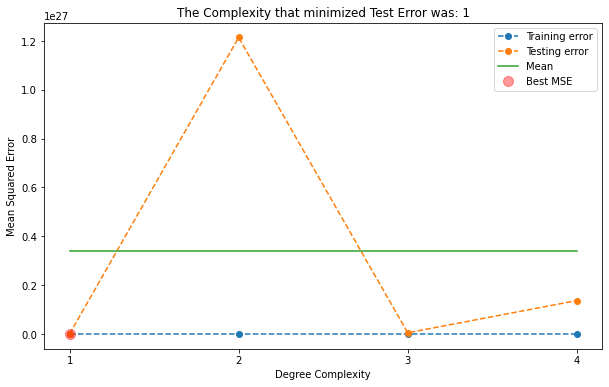

In [21]:
# check effectiveness of complexity!
plt.subplots(figsize=(10, 6))
plt.plot(range(1, complexity), train_mses, '--o', label = 'Training error')
plt.plot(range(1, complexity), test_mses, '--o', label = 'Testing error')
plt.plot(range(1, complexity), [np.mean(test_mses)]*(complexity-1), '-', label = 'Mean')
plt.plot(np.argmin(test_mses)+1, min(test_mses), 'ro', markersize = 10, alpha = 0.4, label = 'Best MSE')
plt.xticks(range(1, complexity), range(1, complexity))
plt.xlabel('Degree Complexity')
plt.ylabel('Mean Squared Error')
plt.title(f'The Complexity that minimized Test Error was: {test_mses.index(min(test_mses)) + 1}')
plt.legend()
plt.show()

PolynomialFeatures degree is not improving model performance, so, continuing as degree = 1.

### Feature Engineering

In [110]:
# Variance Inflation Factor (VIF)
# Check multicollinearity if any column is greater than 5
def vif(data):
    columns = data.columns
    vif_dict = {}

    for col in data.select_dtypes(include=np.number).columns:
        exclude_col = [i for i in columns if i!=col]
        X,y = data[exclude_col], data[col]

        features = [c for c in data.select_dtypes(include = 'category').columns]
        ohe_step = make_column_transformer((OneHotEncoder(drop = 'if_binary'), features), remainder="passthrough" )
        # fit model with training set
        pipe = Pipeline([('transformer', ohe_step),
                         ('scaler', StandardScaler()),
                         ('ttr_ridge', TransformedTargetRegressor(func=np.log1p,
                                                                    inverse_func=np.expm1,
                                                                    regressor=Ridge(alpha = 0.0000001))) ])
        # vif = 1 / (1- R^2)
        r_squared = pipe.fit(X, y).score(X, y)
        if r_squared == 1:
            vif = 0
        else:
            vif = 1 / (1-r_squared)
        vif_dict[col] = vif

    df_vif = pd.DataFrame({"VIF":vif_dict}).sort_values(by = "VIF", ascending = False)
    return df_vif

In [111]:
vif(X)

,VIF
AGE,36.718960
EDUCATION,28.921778
EXPERIENCE,2.550234


In [24]:
vif(X.drop(columns='AGE', axis=1))

,VIF
EDUCATION,1.915346
EXPERIENCE,1.204159


## Remove AGE Feature

The EXPERIENCE and AGE are strongly linearly correlated.

The AGE coefficient is expressed in “dollars/hour per living years” while the EDUCATION one is expressed in “dollars/hour per years of education”. This representation of the coefficients has the benefit of making clear the practical predictions of the model: an increase of 
1
 year in AGE means a decrease of 
0.030867
 dollars/hour, while an increase of 
1
 year in EDUCATION means an increase of 
0.054699
 dollars/hour. On the other hand, categorical variables (as UNION or SEX) are adimensional numbers taking either the value 0 or 1. Their coefficients are expressed in dollars/hour. Then, we cannot compare the magnitude of different coefficients since the features have different natural scales, and hence value ranges, because of their different unit of measure. This is more visible if we plot the coefficients.
 
 
 

In [112]:
# Reset X set
X = survey.drop(columns='WAGE')
# Drop AGE
X.drop(columns='AGE', axis = 1, inplace = True)
# split data again without AGE
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 93, test_size = 0.3)

#### Encoder

In [26]:
# Encoder and Scaler Step
features = X.select_dtypes(include = 'category').columns
ohe_step = make_column_transformer( (OneHotEncoder(drop = 'if_binary'), features),
                                   (StandardScaler(), X.select_dtypes(include=np.number).columns) )
#                                   ,remainder = 'passthrough' )

#### Regression Models

In [27]:
%%time
# LinearRegression
ttrl_pipe = Pipeline([('transformer', ohe_step),
#                      ('scaler', StandardScaler()),
                      ('ttregressor', TransformedTargetRegressor(func = np.log1p,
                                                                inverse_func = np.expm1,
                                                                regressor = LinearRegression(fit_intercept=False))) ])
#fit on train
ttrl_pipe.fit(X_train, y_train)
ttrl_train_acc = ttrl_pipe.score(X_train, y_train)
ttrl_test_acc = ttrl_pipe.score(X_test, y_test)
ttrl_test_mse  = mean_squared_error(y_test, ttrl_pipe.predict(X_test))
print('Train Score          :', ttrl_train_acc)
print('Test Score           :', ttrl_test_acc)
print('Test MSE             :', ttrl_test_mse)
# Train Score          : 0.31883793422997697
# Test Score           : 0.2427207805974474
# Test MSE             : 21.766189263137324
# CPU times: user 109 ms, sys: 4.26 ms, total: 113 ms
# Wall time: 22.4 ms
ttrl_model = ttrl_pipe

Train Score          : 0.3192580641324553
Test Score           : 0.23035435719490527
Test MSE             : 22.121632678711542
CPU times: user 223 ms, sys: 6.51 ms, total: 230 ms
Wall time: 28.8 ms


#### Plot coefficients to analyze

In [28]:
ttrl_coefs = pd.DataFrame(
    ttrl_pipe[-1].regressor_.coef_,
    columns=["Coefficients"],
    index=ttrl_pipe[:-1].get_feature_names_out(),
)
ttrl_coefs.loc[abs(ttrl_coefs).sort_values(by='Coefficients', ascending = False).index]

,Coefficients
onehotencoder__SECTOR_Manufacturing,0.991418
onehotencoder__RACE_Hispanic,0.949934
onehotencoder__RACE_White,0.928243
onehotencoder__SECTOR_Other,0.880380
onehotencoder__SECTOR_Construction,0.869816
onehotencoder__RACE_Other,0.863438
onehotencoder__OCCUPATION_Management,0.581078
onehotencoder__OCCUPATION_Professional,0.562641
onehotencoder__OCCUPATION_Clerical,0.471653
onehotencoder__OCCUPATION_Other,0.442650


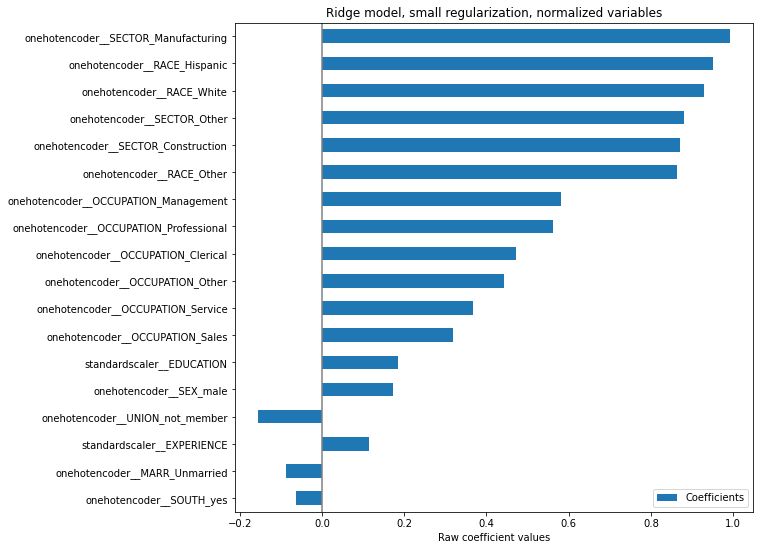

In [29]:
ttrl_coefs.loc[abs(ttrl_coefs).sort_values(by='Coefficients', ascending = True).index].plot.barh(figsize=(12, 9))
plt.title("Ridge model, small regularization, normalized variables")
plt.xlabel("Raw coefficient values")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)
plt.show()

Indeed, from the plot above the most important factor in determining WAGE appears to be the variable UNION, even if our intuition might tell us that variables like EXPERIENCE should have more impact.

Looking at the coefficient plot to gauge feature importance can be misleading as some of them vary on a small scale, while others, like AGE, varies a lot more, several decades.

This is visible if we compare the standard deviations of different features.

The plot above tells us about dependencies between a specific feature and the target when all other features remain constant, i.e., conditional dependencies. An increase of the AGE will induce a decrease of the WAGE when all other features remain constant. On the contrary, an increase of the EXPERIENCE will induce an increase of the WAGE when all other features remain constant. Also, AGE, EXPERIENCE and EDUCATION are the three variables that most influence the model.


In [30]:
# plt.subplots(figsize=(10, 6))
# plt.ylabel("Age coefficient")
# plt.xlabel("Experience coefficient")
# plt.grid(True)
# plt.xlim(-0.4, 0.5)
# plt.ylim(-0.4, 0.5)
# plt.scatter(ttrl_coefs["standardscaler__AGE"], ttrl_coefs["standardscaler__EXPERIENCE"])
# plt.title("Co-variations of coefficients for AGE and EXPERIENCE across folds")
# plt.show()

### Check Coefficient Importance Variability

In [31]:
%%time
feature_names = ttrl_pipe[:-1].get_feature_names_out()
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=93)
cv_model = cross_validate(
    ttrl_pipe,
    X,
    y,
    cv=cv,
    return_estimator=True,
    n_jobs=2,
)
coefs = pd.DataFrame(
    [est[-1].regressor_.coef_ for est in cv_model["estimator"]], columns=feature_names
)

CPU times: user 137 ms, sys: 53 ms, total: 190 ms
Wall time: 1.62 s


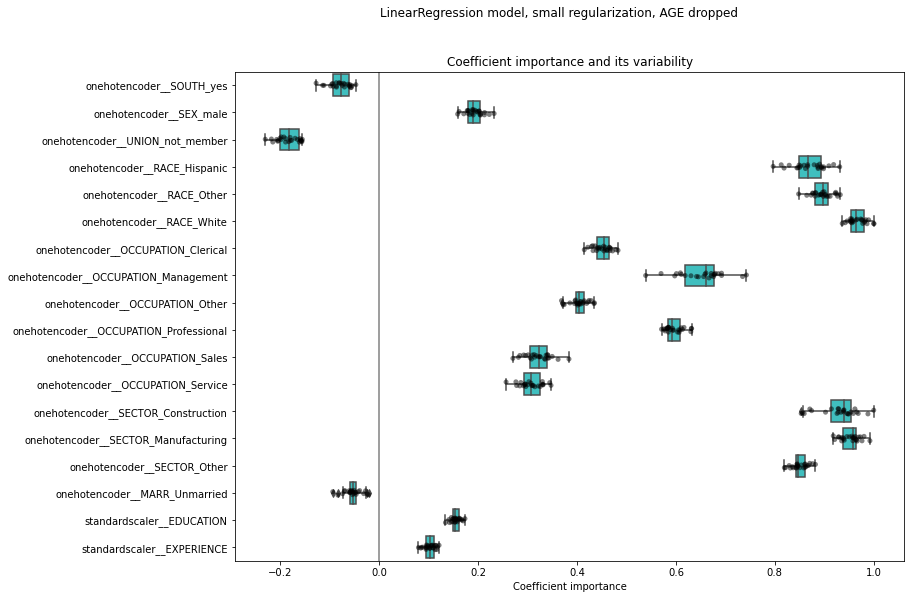

In [32]:
plt.figure(figsize=(12, 9))
sns.stripplot(data=coefs, orient="h", color="k", alpha=0.5)
sns.boxplot(data=coefs, orient="h", color="cyan", saturation=0.5)
plt.axvline(x=0, color=".5")
plt.title("Coefficient importance and its variability")
plt.xlabel("Coefficient importance")
plt.suptitle("LinearRegression model, small regularization, AGE dropped")
#plt.subplots_adjust(left=0.3)
plt.show()

In [33]:
%%time
# KNeighborsRegressor()
# 
knn_pipe = Pipeline([('transformer', ohe_step),
#                     ('scaler', StandardScaler()),
                     ('model',  KNeighborsRegressor())
                    ])
knn_param_dict = {'model__n_neighbors': [9,10,12,14,16,18], 'model__weights': ['uniform', 'distance']}

knn_grid = GridSearchCV(knn_pipe, param_grid = knn_param_dict)
#fit on train
knn_grid.fit(X_train, y_train)
knn_train_acc = knn_grid.best_estimator_.score(X_train, y_train)
knn_test_acc = knn_grid.best_estimator_.score(X_test, y_test)
knn_test_mse  = mean_squared_error(y_test, knn_grid.best_estimator_.predict(X_test))
knn_model = knn_grid.best_estimator_
print('Train Score          :', knn_train_acc)
print('Test Score           :', knn_test_acc)
print('Test MSE             :', knn_test_mse)
print('Best Parameters      :', knn_grid.best_params_)
print('Best Estimator Reults:', knn_model)
# Results
# Train Score          : 0.312528739097947
# Test Score           : 0.23910481361954805
# Test MSE             : 21.870121629949534
# Best Parameters      : {'model__n_neighbors': 16, 'model__weights': 'uniform'}


Train Score          : 0.34017327714230594
Test Score           : 0.2208061127229457
Test MSE             : 22.396074246606855
Best Parameters      : {'model__n_neighbors': 18, 'model__weights': 'uniform'}
Best Estimator Reults: Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  Index(['SOUTH', 'SEX', 'UNION', 'RACE', 'OCCUPATION', 'SECTOR', 'MARR'], dtype='object')),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  Index(['EDUCATION', 'EXPERIENCE'], dtype='object'))])),
                ('model', KNeighborsRegressor(n_neighbors=18))])
CPU times: user 14.9 s, sys: 1.91 s, total: 16.8 s
Wall time: 1.24 s


In [34]:
knn_grid.best_estimator_[-1]
knn_grid.best_estimator_.named_steps['model']

KNeighborsRegressor(n_neighbors=18)

In [35]:
%%time
# SVR()
# 
svr_pipe = Pipeline([('transformer', ohe_step),
#                     ('scaler', StandardScaler()),
                     ('model',  SVR())
                    ])
svr_param_dict = {'model__kernel': ['linear', 'rbf', 'sigmoid', 'poly']}

svr_grid = GridSearchCV(svr_pipe, param_grid = svr_param_dict)
#fit on train
svr_grid.fit(X_train, y_train)
svr_train_acc = svr_grid.best_estimator_.score(X_train, y_train)
svr_test_acc = svr_grid.best_estimator_.score(X_test, y_test)
svr_test_mse  = mean_squared_error(y_test, svr_grid.best_estimator_.predict(X_test))
svr_model = svr_grid.best_estimator_
print('Train Score          :', svr_train_acc)
print('Test Score           :', svr_test_acc)
print('Test MSE             :', svr_test_mse)
print('Best Parameters      :', svr_grid.best_params_)
print('Best Estimator Reults:', svr_model)
# Results
# Train Score          : 0.3213578110595562
# Test Score           : 0.24873883265148444
# Test MSE             : 21.593214676422892
# Best Parameters      : {'model__kernel': 'linear'}


Train Score          : 0.315487660058429
Test Score           : 0.23500204973067162
Test MSE             : 21.988045815664947
Best Parameters      : {'model__kernel': 'linear'}
Best Estimator Reults: Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  Index(['SOUTH', 'SEX', 'UNION', 'RACE', 'OCCUPATION', 'SECTOR', 'MARR'], dtype='object')),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  Index(['EDUCATION', 'EXPERIENCE'], dtype='object'))])),
                ('model', SVR(kernel='linear'))])
CPU times: user 2.35 s, sys: 256 ms, total: 2.61 s
Wall time: 437 ms


In [36]:
%%time
# DecisionTreeRegressor()
# 
dtr_pipe = Pipeline([('transformer', ohe_step),
#                     ('scaler', StandardScaler()),
                     ('model',  DecisionTreeRegressor())
                    ])
dtr_param_dict = {'model__max_depth': [1,2,3,4,5,6,7,8,9,10,12,14,16,18], 'model__splitter':['best', 'random']}

dtr_grid = GridSearchCV(dtr_pipe, param_grid = dtr_param_dict)
#fit on train
dtr_grid.fit(X_train, y_train)
dtr_train_acc = dtr_grid.best_estimator_.score(X_train, y_train)
dtr_test_acc = dtr_grid.best_estimator_.score(X_test, y_test)
dtr_test_mse  = mean_squared_error(y_test, dtr_grid.best_estimator_.predict(X_test))
dtr_model = dtr_grid.best_estimator_
print('Train Score          :', dtr_train_acc)
print('Test Score           :', dtr_test_acc)
print('Test MSE             :', dtr_test_mse)
print('Best Parameters      :', dtr_grid.best_params_)
print('Best Estimator Reults:', dtr_model)
# Results
# Train Score          : 0.17926822631743877
# Test Score           : 0.19187928690871214
# Test MSE             : 23.227507025062273
# Best Parameters      : {'model__max_depth': 2, 'model__splitter': 'random'}


Train Score          : 0.15316982053278705
Test Score           : 0.13813385413523316
Test MSE             : 24.772291606236568
Best Parameters      : {'model__max_depth': 1, 'model__splitter': 'best'}
Best Estimator Reults: Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  Index(['SOUTH', 'SEX', 'UNION', 'RACE', 'OCCUPATION', 'SECTOR', 'MARR'], dtype='object')),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  Index(['EDUCATION', 'EXPERIENCE'], dtype='object'))])),
                ('model', DecisionTreeRegressor(max_depth=1))])
CPU times: user 1.52 s, sys: 8.6 ms, total: 1.52 s
Wall time: 1.52 s


In [37]:
%%time
# Ridge
# 
# Find best alpha for Ridge regressor
ttrr_pipe = Pipeline([('transformer', ohe_step),
#                      ('scaler', StandardScaler()),
                      ('ttregressor', TransformedTargetRegressor(func=np.log1p,
                                                                 inverse_func=np.expm1,
                                                                 regressor=Ridge())) ])
ttrr_param_dict = {'ttregressor__regressor__alpha':
              [0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 1.0, 10.0, 100.0, 1000.0]}
ttrr_grid = GridSearchCV(ttrr_pipe, param_grid = ttrr_param_dict)
#fit on train
ttrr_grid.fit(X_train, y_train)
ttrr_train_acc = ttrr_grid.best_estimator_.score(X_train, y_train)
ttrr_test_acc = ttrr_grid.best_estimator_.score(X_test, y_test)
ttrr_test_mse  = mean_squared_error(y_test, ttrr_grid.best_estimator_.predict(X_test))
ttrr_model = ttrr_grid.best_estimator_
print('Train Score          :', ttrr_train_acc)
print('Test Score           :', ttrr_test_acc)
print('Test MSE             :', ttrr_test_mse)
print('Best Parameters      :', ttrr_grid.best_params_)
print('Best Estimator Reults:', ttrr_model)
# Results
# Train Score          : 0.31696934511869224
# Test Score           : 0.2317614742701215
# Test MSE             : 22.081188446531616
# Best Parameters      : {'ttregressor__regressor__alpha': 10.0}


Train Score          : 0.3136501791944327
Test Score           : 0.22302562560422634
Test MSE             : 22.332279630026672
Best Parameters      : {'ttregressor__regressor__alpha': 10.0}
Best Estimator Reults: Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  Index(['SOUTH', 'SEX', 'UNION', 'RACE', 'OCCUPATION', 'SECTOR', 'MARR'], dtype='object')),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  Index(['EDUCATION', 'EXPERIENCE'], dtype='object'))])),
                ('ttregressor',
                 TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                            inverse_func=<ufunc 'expm1'>,
                                            regres

In [38]:
%%time
voter1 = VotingRegressor(estimators=[('ttr', ttrl_model ),
                                    ('knn', knn_model ),
                                    ('svm', svr_model ),
                                    ('dtr', dtr_model ),
                                    ('rid', ttrr_model )
                                   ],
                        verbose = True).fit(X_train, y_train)

vote1_train_acc = voter1.score(X_train, y_train)
vote1_test_acc = voter1.score(X_test, y_test)
vote1_test_mse  = mean_squared_error(y_test, voter1.predict(X_test))
print('Train Score          :', vote1_train_acc)
print('Test Score           :', vote1_test_acc)
print('Test MSE             :', vote1_test_mse)
#vote_accuracy
# Train Score          : 0.3773810197753751
# Test Score           : 0.26625811923648635
# Test MSE             : 21.089664469584868


[Voting] ...................... (1 of 5) Processing ttr, total=   0.0s
[Voting] ...................... (2 of 5) Processing knn, total=   0.0s
[Voting] ...................... (3 of 5) Processing svm, total=   0.0s
[Voting] ...................... (4 of 5) Processing dtr, total=   0.0s
[Voting] ...................... (5 of 5) Processing rid, total=   0.0s
Train Score          : 0.3314885681486821
Test Score           : 0.24219605730890081
Test MSE             : 21.781271185520314
CPU times: user 1.57 s, sys: 210 ms, total: 1.78 s
Wall time: 155 ms


In [39]:
%%time
# adjust weights!
voter2 = VotingRegressor(estimators=[('ttr', ttrl_model ),
                                    ('knn', knn_model ),
                                    ('svm', svr_model ),
                                    ('dtr', dtr_model ),
                                    ('rid', ttrr_model )
                                   ],
                        verbose = True, weights=[4,6,6,1,4]).fit(X_train, y_train)
vote2_train_acc = voter2.score(X_train, y_train)
vote2_test_acc = voter2.score(X_test, y_test)
vote2_test_mse  = mean_squared_error(y_test, voter2.predict(X_test))
print('Train Score          :', vote2_train_acc)
print('Test Score           :', vote2_test_acc)
print('Test MSE             :', vote2_test_mse)
#vote_accuracy
# Train Score          : 0.4038844940272692
# Test Score           : 0.2737518104872615
# Test MSE             : 20.874276145351473


[Voting] ...................... (1 of 5) Processing ttr, total=   0.0s
[Voting] ...................... (2 of 5) Processing knn, total=   0.0s
[Voting] ...................... (3 of 5) Processing svm, total=   0.0s
[Voting] ...................... (4 of 5) Processing dtr, total=   0.0s
[Voting] ...................... (5 of 5) Processing rid, total=   0.0s
Train Score          : 0.34293386205548515
Test Score           : 0.24464896091288857
Test MSE             : 21.710768307954556
CPU times: user 1.97 s, sys: 384 ms, total: 2.35 s
Wall time: 176 ms


In [40]:
# ttrl_coefs = pd.DataFrame(
#     ttrl_pipe[-1].regressor_.coef_,
#     columns=["Coefficients"],
#     index=ttrl_pipe[:-1].get_feature_names_out(),
# )
# abs(coefs).sort_values(by='Coefficients', ascending = False)
voter2.get_feature_names_out()
voter2.named_estimators.dtr[-1]

DecisionTreeRegressor(max_depth=1)

In [41]:
# %%time
# # adjust weights!
# voter = VotingRegressor(estimators=[('ttr', Pipeline([('transformer', ohe_step),
#                                                       ('scaler', StandardScaler()),
#                                                       ('model', TransformedTargetRegressor(func=np.log1p,
#                                                                 inverse_func=np.expm1,
#                                                                 regressor = LinearRegression()))
#                                                      ]) ),
#                                     ('knn', Pipeline([('transformer', ohe_step),
#                                                       ('scaler', StandardScaler()),
#                                                       ('model', KNeighborsRegressor())
#                                                      ]) ),
#                                     ('svm', Pipeline([('transformer', ohe_step),
#                                                       ('scaler', StandardScaler()),
#                                                       ('model', SVR())
#                                                      ]) ),
#                                     ('dtr', Pipeline([('transformer', ohe_step),
#                                                       ('scaler', StandardScaler()),
#                                                       ('model', DecisionTreeRegressor(max_depth = 1))
#                                                      ]) ),
#                                     ('rid', Pipeline([('transformer', ohe_step),
#                                                       ('scaler', StandardScaler()),
#                                                       ('model', Ridge())
#                                                      ]) )
#                                    ],
#                         verbose = True, weights=[.05,.3,.3,.05,.3]).fit(X_train, y_train)
# vote_accuracy = voter.score(X_test, y_test)
# vote_test_mse = mean_squared_error(y_test, voter.predict(X_test))
# print('Score                :', vote_accuracy)
# print('Test MSE             :', vote_test_mse)
# #vote_accuracy
# # lgr: 0.2292287145373867
# # knn: 0.18934410203345298
# # svm: 0.24412572805489052
# # dtr: 0.13813385413523316
# # rid: 0.24627331034921185

### Plot Results

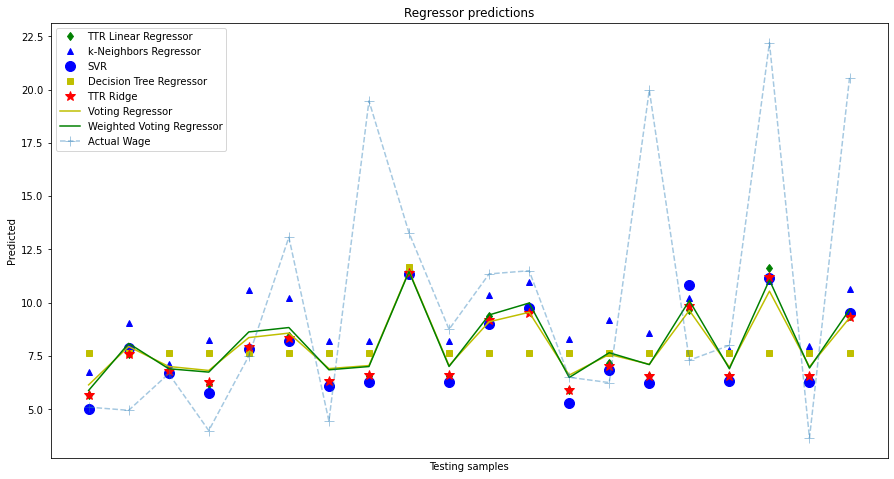

In [102]:
# 20 samples to try with each model!
x_sample = X[:20]
y_true   = y[:20]

pred1 = ttrl_model.predict(x_sample)
pred2 = knn_model.predict(x_sample)
pred3 = svr_model.predict(x_sample)
pred4 = dtr_model.predict(x_sample)
pred5 = ttrr_model.predict(x_sample)
pred6 = voter1.predict(x_sample)
pred7 = voter2.predict(x_sample)

plt.figure(figsize=(15,8))
plt.plot(pred1, "gd", label="TTR Linear Regressor")
plt.plot(pred2, "b^", label="k-Neighbors Regressor")
plt.plot(pred3, "bo", ms=10, label="SVR")
plt.plot(pred4, "ys", label="Decision Tree Regressor")
plt.plot(pred5, "r*", ms=10, label="TTR Ridge")
plt.plot(pred6, "y-", ms=10, label="Voting Regressor")
plt.plot(pred7, "g-", ms=10, label="Weighted Voting Regressor")
plt.plot(y_true, "+--", ms=10, alpha=0.4, label="Actual Wage")

plt.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
plt.ylabel("Predicted")
plt.xlabel("Testing samples")
plt.legend(loc="best")
plt.title("Regressor predictions")

plt.show()

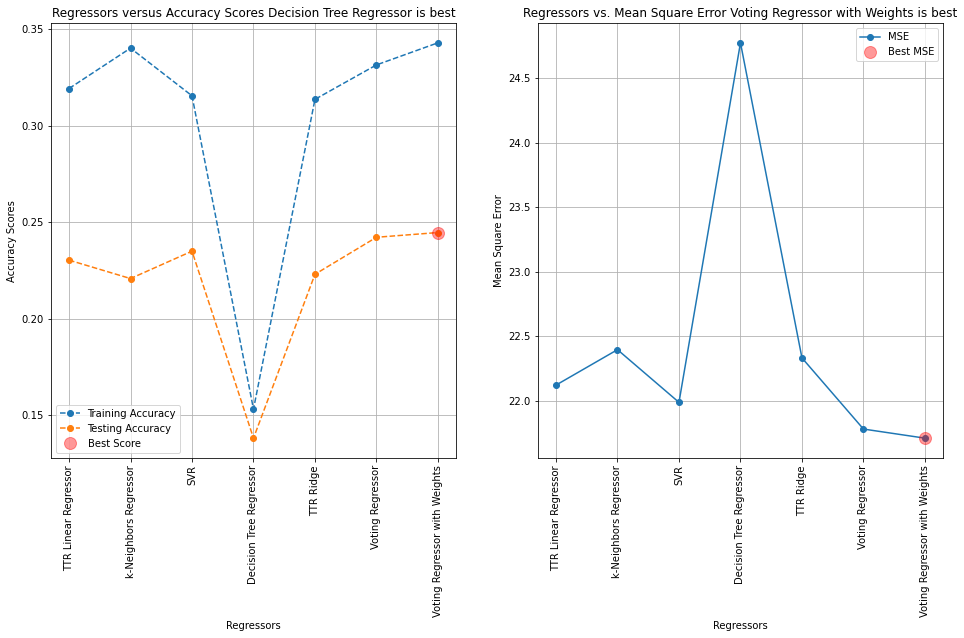

In [42]:
# Time spent
# set metrics!
grid_options=['TTR Linear Regressor', 'k-Neighbors Regressor', 'SVR', 'Decision Tree Regressor', 'TTR Ridge',
              'Voting Regressor', 'Voting Regressor with Weights']
train_accs = [ttrl_train_acc, knn_train_acc, svr_train_acc, dtr_train_acc, ttrr_train_acc,
              vote1_train_acc, vote2_train_acc]
test_accs  = [ttrl_test_acc, knn_test_acc, svr_test_acc, dtr_test_acc, ttrr_test_acc,
              vote1_test_acc, vote2_test_acc]

#elapsed_times = [lgr_time*5, dtr_time*5, mnb_time*5]
test_mses  = [ttrl_test_mse, knn_test_mse, svr_test_mse, dtr_test_mse, ttrr_test_mse,
              vote1_test_mse, vote2_test_mse]

# plot accuracy and time elapsed
fig, ax = plt.subplots(1, 2, figsize = (16, 8))
ax[0].plot(grid_options, train_accs, '--o', label = 'Training Accuracy')
ax[0].plot(grid_options, test_accs, '--o', label = 'Testing Accuracy')
ax[0].plot(np.argmax(test_accs), max(test_accs), 'ro', markersize = 12, alpha = 0.4, label = 'Best Score')
ax[0].tick_params(axis='x', rotation=90)
ax[0].set_xlabel('Regressors')
ax[0].set_ylabel('Accuracy Scores')
ax[0].set_title(f'Regressors versus Accuracy Scores {grid_options[np.argmin(test_accs)]} is best')
ax[0].legend()
ax[0].grid(True)

# MSE plot
ax[1].plot(grid_options, test_mses, '-o', label = 'MSE')
ax[1].tick_params(axis='x', rotation=90)
ax[1].set_xlabel('Regressors')
ax[1].set_ylabel('Mean Square Error')
ax[1].set_title(f'Regressors vs. Mean Square Error {grid_options[np.argmin(test_mses)]} is best')
ax[1].plot(np.argmin(test_mses), min(test_mses), 'ro', markersize = 12, alpha = 0.4, label = 'Best MSE')
ax[1].legend()
ax[1].grid(True)

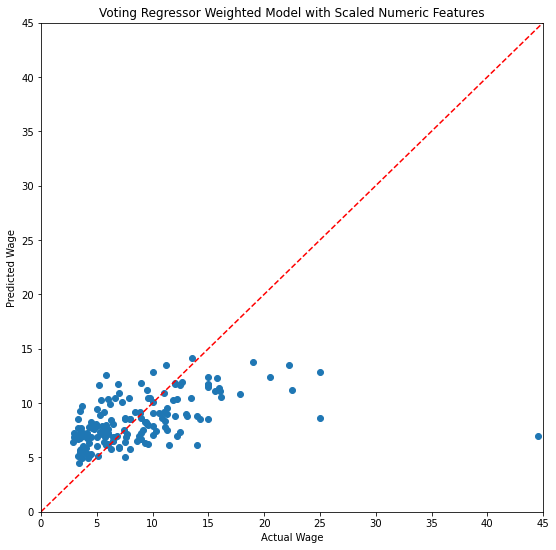

In [58]:
y_pred = voter2.predict(X_test)
plt.subplots(figsize=(9, 9))
plt.scatter(y_test, y_pred)
plt.plot([0, 50], [0, 50], ls='--', c='red')

#plt.text(3, 30, f'\nMedian Absolute Error on testing set: {median_absolute_error(y_test, y_pred):.2f} $/hour') 
#plt.text(3, 29, f'\nMean Absolute Error on testing set  : {mean_absolute_error(y_test, y_pred):.2f} $/hour') 

plt.title("Voting Regressor Weighted Model with Scaled Numeric Features")
plt.ylabel("Predicted Wage")
plt.xlabel("Actual Wage")
plt.xlim([0, 45])
plt.ylim([0, 45])
plt.show()

In [61]:
len(survey[survey['WAGE'] > 16])

46

### Coefficient Analysis

In [44]:
#voter2.
voter2.score(X, y, sample_weight=None)

0.3117094641070882

#### Permutation Importance

In [65]:
# permutation importance
# function to execute permutation importance!
def column_importance():
    # fit model with training set
    print('model r^2 :', voter2.score(X_test, y_test))
    # permutation importance
    r = permutation_importance(voter2, X_test, y_test, n_repeats = 50, random_state = 93)
    print('importance:', r.importances_mean)
    return pd.DataFrame({"Column":X.columns, "Importance":r.importances_mean}).sort_values(
        by = "Importance", ascending = False)

In [66]:
%%time
fi = column_importance()
fi

model r^2 : 0.24464896091288857
importance: [ 0.24928062  0.00718741  0.04767128  0.06218456  0.02043138  0.00197891
  0.07077919  0.00344726 -0.00868703]
CPU times: user 2min 50s, sys: 19.2 s, total: 3min 10s
Wall time: 13.3 s


,Column,Importance
0,EDUCATION,0.249281
6,OCCUPATION,0.070779
3,EXPERIENCE,0.062185
2,SEX,0.047671
4,UNION,0.020431
1,SOUTH,0.007187
7,SECTOR,0.003447
5,RACE,0.001979
8,MARR,-0.008687


In [85]:
range(0, len(fi))

range(0, 9)

In [90]:
fi.reset_index().sort_values(by='index')['Column'].index

Int64Index([0, 5, 3, 2, 4, 7, 1, 6, 8], dtype='int64')

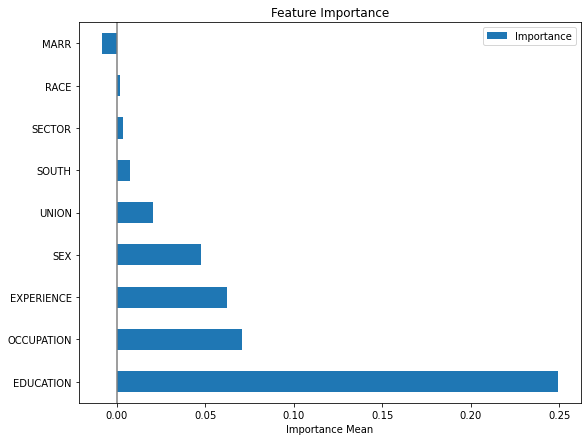

In [91]:
fi.plot.barh(figsize=(9, 7))
plt.title('Feature Importance')
plt.xlabel('Importance Mean')
plt.axvline(x=0, color='.5')
#plt.subplots_adjust(left=0.3)
#plt.yticks(ticks=fi.index, labels=fi['Column'])
plt.yticks(ticks=fi.reset_index().sort_values(by='index')['Column'].index,
            labels=fi.reset_index().sort_values(by='index')['Column'])
plt.show()

### Next Steps
Model seems high variance, we may need to go with `BaggingRegressor` to see if helps

In [48]:
%%time
# bagging
bagged = Pipeline([('transformer', ohe_step),
                   ('model',  BaggingRegressor(random_state = 93))
                  ])

bagged.fit(X_train, y_train)
bagged_accuracy = bagged.score(X_test, y_test)
bagged_test_mse = mean_squared_error(y_test, bagged.predict(X_test))
print('Score                :', bagged_accuracy)
print('Test MSE             :', bagged_test_mse)
# Score                : 0.12496268344329842
# Test MSE             : 25.150865567798483


Score                : 0.12496268344329842
Test MSE             : 25.150865567798483
CPU times: user 34.7 ms, sys: 1.56 ms, total: 36.3 ms
Wall time: 35.3 ms


In [49]:
%%time
# bagging to pasting
bagged = Pipeline([('transformer', ohe_step),
                   ('model',  BaggingRegressor(random_state = 93, bootstrap = False))
                  ])

bagged.fit(X_train, y_train)
bagged_accuracy = bagged.score(X_test, y_test)
bagged_test_mse = mean_squared_error(y_test, bagged.predict(X_test))
print('Score                :', bagged_accuracy)
print('Test MSE             :', bagged_test_mse)
# Score                : -0.18830497231224097
# Test MSE             : 34.15499893167702


Score                : -0.18830497231224097
Test MSE             : 34.15499893167702
CPU times: user 109 ms, sys: 7.49 ms, total: 116 ms
Wall time: 115 ms


In [50]:
# random forest
rfr = Pipeline([('transformer', ohe_step),
                 ('model',  RandomForestRegressor(random_state = 93, oob_score = True, n_estimators = 37, max_depth = 7))
               ])
rfr.fit(X_train, y_train)
rfr_accuracy = rfr.score(X_test, y_test)
rfr_test_mse = mean_squared_error(y_test, rfr.predict(X_test))
print('Score                :', rfr_accuracy)
print('OOB Score            :', rfr.named_steps['model'].oob_score_)
print('Test MSE             :', rfr_test_mse)
rfr.named_steps['model'].oob_score_
# Score                : 0.2590561231036801
# OOB Score            : 0.17018364850062995
# Test MSE             : 21.296668711722553

Score                : 0.2590561231036801
OOB Score            : 0.17018364850062995
Test MSE             : 21.296668711722553


0.17018364850062995

In [51]:
%%time
# AdaBoostRegressor
params = {'model__n_estimators': [5,6,7,8,9,10,11,12],
          'model__base_estimator__max_depth': [1, 2, 3, 4, 5]}
pipe = Pipeline([('transformer', ohe_step),
                 ('model', AdaBoostRegressor(base_estimator = DecisionTreeRegressor(), random_state = 93))
])
tree_grid = GridSearchCV(pipe, param_grid = params)
tree_grid.fit(X_train, y_train)
abr_accuracy = tree_grid.best_estimator_.score(X_test, y_test)
abr_test_mse = mean_squared_error(y_test, tree_grid.best_estimator_.predict(X_test))
print('Score                :', abr_accuracy)
print('Test MSE             :', abr_test_mse)
print('Best Paremeters      :', tree_grid.best_params_)
# Score                : 0.17099066702356525
# Test MSE             : 23.82790070049489
# Best Paremeters      : {'model__base_estimator__max_depth': 2, 'model__n_estimators': 9}


Score                : 0.17099066702356525
Test MSE             : 23.82790070049489
Best Paremeters      : {'model__base_estimator__max_depth': 2, 'model__n_estimators': 9}
CPU times: user 3.86 s, sys: 20.7 ms, total: 3.88 s
Wall time: 3.88 s


In [52]:
# GradientBoostingRegressor
gbr = Pipeline([('transformer', ohe_step),
                ('model',  GradientBoostingRegressor(random_state = 93, n_estimators = 37, subsample = 1.))
               ])

gbr.fit(X_train, y_train)
gbr_accuracy = gbr.score(X_test, y_test)
gbr_test_mse = mean_squared_error(y_test, gbr.predict(X_test))
print('Score                :', gbr_accuracy)
print('Test MSE             :', gbr_test_mse)
# Score                : 0.27127668480916645
# Test MSE             : 20.945417743561407

Score                : 0.27127668480916645
Test MSE             : 20.945417743561407


In [53]:
# # plot preds versus actual
# plt.scatter(x, y, color = 'blue', alpha = 0.2, label = 'Actual')
# plt.plot(x, reg_pred, '--ro', alpha = 0.2, label = 'Predictions')
# plt.legend()
# plt.show()

In [54]:
tend = datetime.now()
print(tstart, '-', tend)
print(tend-tstart)

2022-08-21 16:21:14.612396 - 2022-08-21 16:21:44.551882
0:00:29.939486


### Manual Tests

In [55]:
# Test
def test_voter(indice):
    return survey.loc[indice], 'Predicted: ' + str(voter2.predict(X.loc[indice:indice])[0]), 'Actual   : ' + str(y[indice])

In [56]:
test_voter(36)

(EDUCATION             12.0
 SOUTH                  yes
 SEX                   male
 EXPERIENCE            20.0
 UNION           not_member
 WAGE                  7.61
 AGE                   38.0
 RACE                 Other
 OCCUPATION           Other
 SECTOR        Construction
 MARR               Married
 Name: 36, dtype: object,
 'Predicted: 7.364535296195235',
 'Actual   : 7.61')